1. carga y reduccion

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.sparse import hstack, csr_matrix 
from sklearn.linear_model import Ridge

ARCHIVO_ORIGINAL = 'flight_data.csv'
ARCHIVO_REDUCIDO = 'dataset_reducido_3M.csv'
FILAS_A_CARGAR = 3000000

df = pd.read_csv(ARCHIVO_ORIGINAL, nrows=FILAS_A_CARGAR)

df.rename(columns={
    'elapsedDays': 'date_diff',
    'startingAirport': 'starting_airport',
    'destinationAirport': 'destination_airport',
    'totalFare': 'total_fare'
}, inplace=True)

df.to_csv(ARCHIVO_REDUCIDO, index=False)

del df

2. Carga y curado

In [15]:
ARCHIVO_REDUCIDO = 'dataset_reducido_3M.csv'
df = pd.read_csv(ARCHIVO_REDUCIDO)

TARGET = 'total_fare'
df['Y'] = df[TARGET]
df.drop(TARGET, axis=1, inplace=True)

# Curado de 'segmentsDistance'
COLUMNA_CON_STRING = 'segmentsDistance' 
df[COLUMNA_CON_STRING] = df[COLUMNA_CON_STRING].astype(str).str.split('\|\|', expand=True)[0]
df[COLUMNA_CON_STRING] = pd.to_numeric(df[COLUMNA_CON_STRING], errors='coerce')
df[COLUMNA_CON_STRING].fillna(0, inplace=True) 

# Feature Engineering
df['flightDate'] = pd.to_datetime(df['flightDate'], errors='coerce')
df['mes_vuelo'] = df['flightDate'].dt.month
df['dia_semana_vuelo'] = df['flightDate'].dt.dayofweek

df['mes_vuelo'].fillna(-1, inplace=True)
df['dia_semana_vuelo'].fillna(-1, inplace=True)

for col in ['isBasicEconomy', 'isRefundable', 'isNonStop']:
    df[col] = df[col].astype(int)

# Transformación Logarítmica
if (df['Y'] > 0).all():
    df['Y_log'] = np.log1p(df['Y'])

<>:10: SyntaxWarning: invalid escape sequence '\|'
<>:10: SyntaxWarning: invalid escape sequence '\|'
C:\Users\Personal\AppData\Local\Temp\ipykernel_5584\4132849684.py:10: SyntaxWarning: invalid escape sequence '\|'
  df[COLUMNA_CON_STRING] = df[COLUMNA_CON_STRING].astype(str).str.split('\|\|', expand=True)[0]
C:\Users\Personal\AppData\Local\Temp\ipykernel_5584\4132849684.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[COLUMNA_CON_STRING].fillna(0, inplace=True)
C:\Users\Personal\AppData\Local\Temp\ipykernel_5584\41328

3. Visualizacion de datos

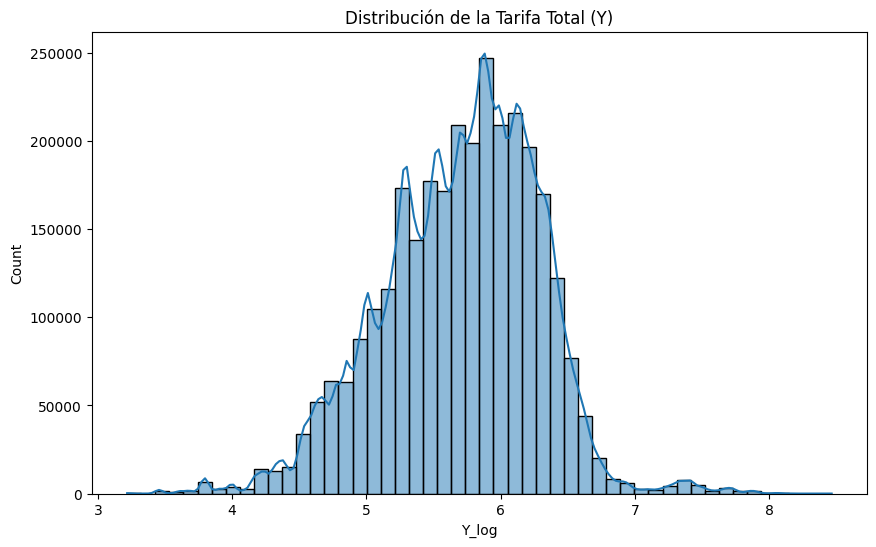

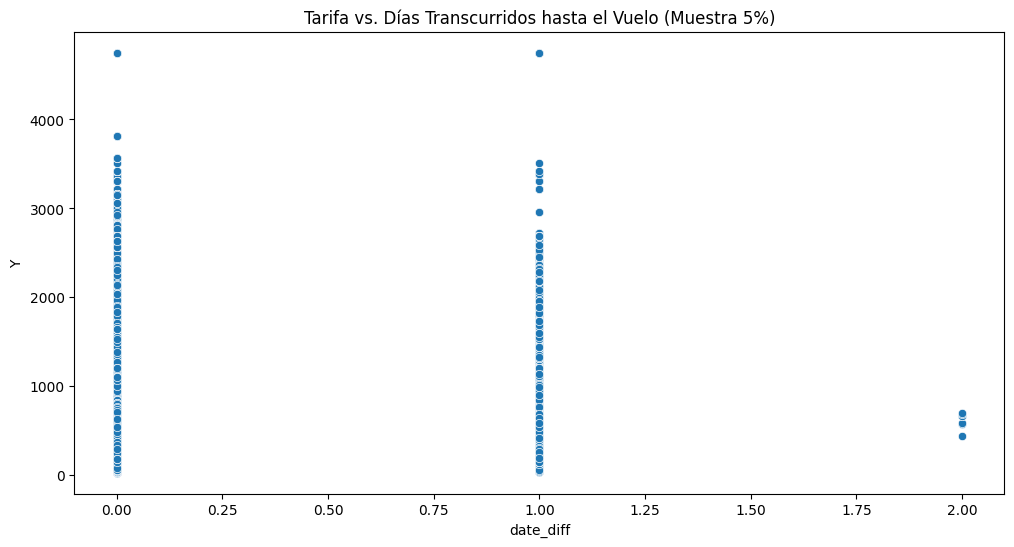

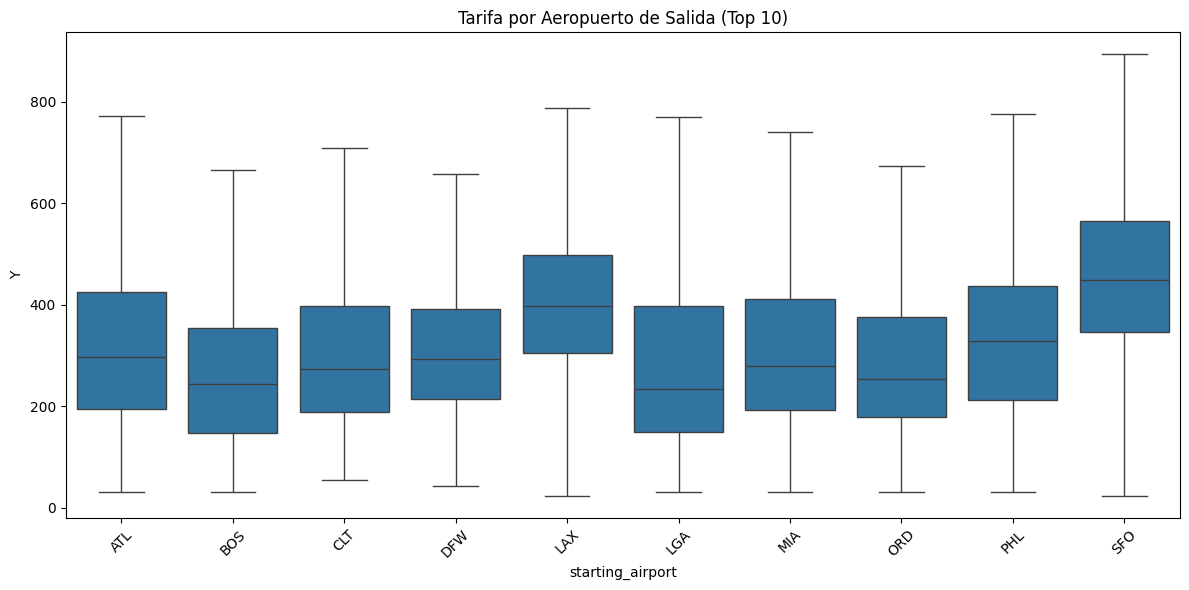

In [7]:
# Definir Y (usamos la transformada si existe)
Y_plot = df['Y_log'] if 'Y_log' in df.columns else df['Y']

# Distribución de la Tarifa Total
plt.figure(figsize=(10, 6))
sns.histplot(Y_plot, bins=50, kde=True)
plt.title('Distribución de la Tarifa Total (Y)')
plt.show()

# Relación entre Días Transcurridos y Tarifa
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date_diff', y='Y', data=df.sample(frac=1)) 
plt.title('Tarifa vs. Días Transcurridos hasta el Vuelo (Muestra 5%)')
plt.show()

# Tarifa por Aeropuerto de Salida (Top 10)
top_10_start = df['starting_airport'].value_counts().nlargest(10).index
df_top = df[df['starting_airport'].isin(top_10_start)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='starting_airport', y='Y', data=df_top, showfliers=False) 
plt.title('Tarifa por Aeropuerto de Salida (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4. Preprocesamiento para SGDRegressor (Matriz Dispersa)

In [16]:
X = df.drop(columns=['Y', 'Y_log', TARGET, 'legId', 'fareBasisCode', 
                     'travelDuration', 'flightDate', 'searchDate'], axis=1, errors='ignore') 
y = df['Y_log'] if 'Y_log' in df.columns else df['Y']

X.fillna(0, inplace=True)

COLUMNAS_OHE = [
    'starting_airport', 
    'destination_airport',
    'mes_vuelo', 
    'dia_semana_vuelo', 
    'isBasicEconomy', 
    'isRefundable', 
    'isNonStop',
    'seatsRemaining'
]

COLUMNAS_CONTINUAS = ['date_diff', 'baseFare', 'totalTravelDistance', 'segmentsDistance']

# Escalamiento de Características Continuas
scaler_X = StandardScaler()
X_continuas = X[COLUMNAS_CONTINUAS]
X_continuas_scaled_np = scaler_X.fit_transform(X_continuas.astype(float)) # Escala y convierte a NumPy

# Conversión a matriz dispersa de Continuas
X_continuas_sparse = csr_matrix(X_continuas_scaled_np) 

# One-Hot Encoding con salida dispersa
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True) 
X_encoded_sparse = encoder.fit_transform(X[COLUMNAS_OHE])

# Combinación de matrices dispersas
X_final_sparse = hstack([X_continuas_sparse, X_encoded_sparse])

# División de Datos
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(
    X_final_sparse, y, test_size=0.2, random_state=42
)

5. Entrenamiento y Evaluación del Modelo (SGDRegressor)

In [17]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# CAMBIO CLAVE: Se usa Ridge Regression con alpha=1.0 para regularización L2.
# Esto previene que los coeficientes crezcan demasiado, corrigiendo el R2 negativo.
modelo_ridge = Ridge(alpha=1.0) 
modelo_ridge.fit(X_train_sparse, y_train_scaled)

y_pred_test_scaled = modelo_ridge.predict(X_test_sparse)

y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

if 'Y_log' in df.columns:
    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred_test)
else:
    y_test_real = y_test
    y_pred_real = y_pred_test

mae_test = mean_absolute_error(y_test_real, y_pred_real)
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2_test = r2_score(y_test_real, y_pred_real)

print(f"--- Métrica del Modelo Ridge Regression (en moneda) ---")
print(f"Error Absoluto Medio (MAE) en Test: ${mae_test:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE) en Test: ${rmse_test:.2f}")
print(f"Coeficiente de Determinación (R²) en Test: {r2_test:.4f}")

--- Métrica del Modelo Ridge Regression (en moneda) ---
Error Absoluto Medio (MAE) en Test: $82.87
Raíz del Error Cuadrático Medio (RMSE) en Test: $1585.28
Coeficiente de Determinación (R²) en Test: -50.3223


6. Análisis de Residuales

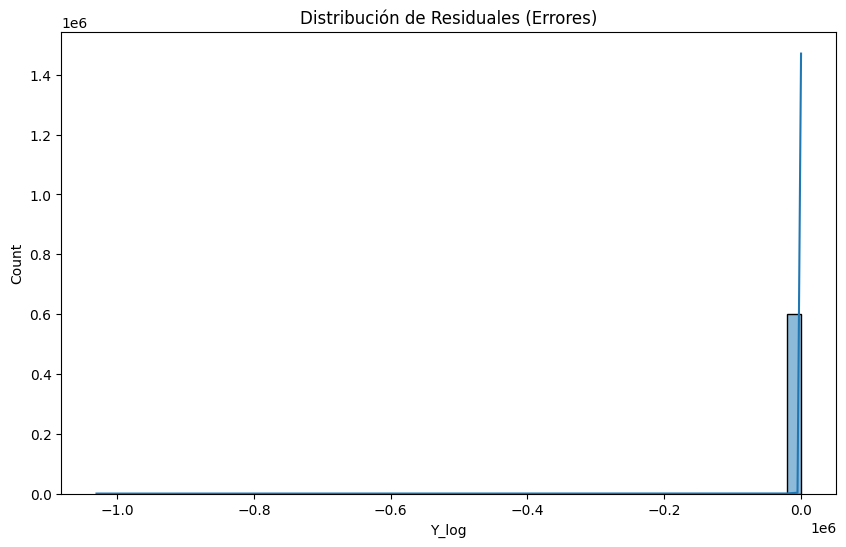

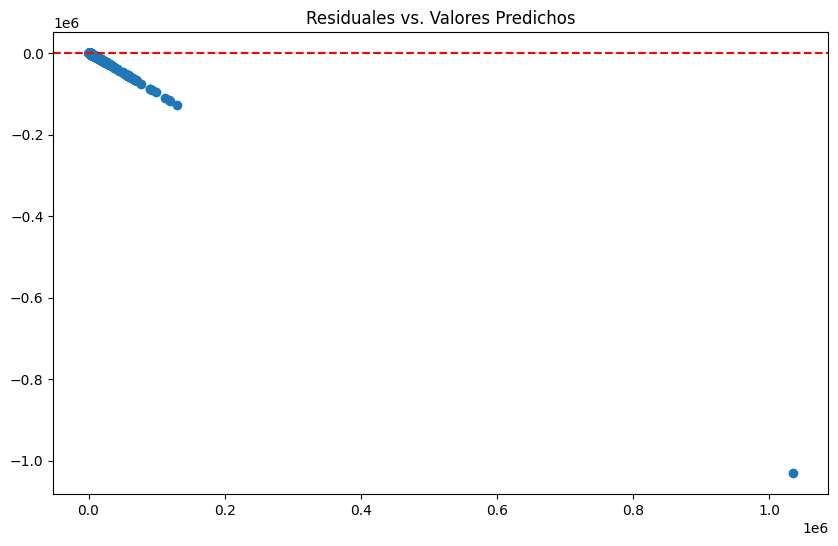

In [18]:
residuales = y_test_real - y_pred_real

plt.figure(figsize=(10, 6))
sns.histplot(residuales, bins=50, kde=True)
plt.title('Distribución de Residuales (Errores)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_real, residuales)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuales vs. Valores Predichos')
plt.show()